In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
import seaborn as sea
import cmath
import pandas as pd
%matplotlib inline


Dont need to show the graph
the length of  z = 1
LPF size (161,)
Z row and colum 1 28160
before conv = (563200,)
after conv (563360,)
final= (563117,)


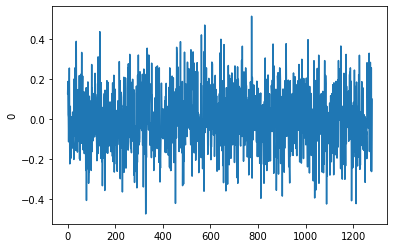

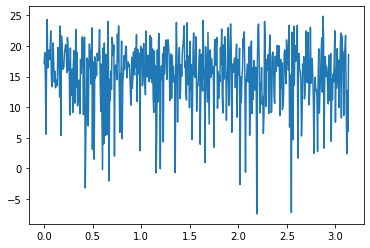

In [2]:
def generate_frame(frame_size, switch_graph):
    
    b = np.random.randint(low= 0, high= 2, size= (frame_size, 1))
    
    if switch_graph == 1:
        #plt.stem(b, use_line_collection=True)
        pass
    
    return b

def encode_hamming(b, G,n_zero_padded_bits, switch_off):
    
    if switch_off == 1:
        N = len(b) // 4
        b_new = np.reshape(b, (4, N))
        c_new = np.dot(G, b_new)
        c_mod = np.mod(c_new, 2)
        row, col = c_mod.shape
        c_new_shape = np.reshape(c_mod, (row*col, 1))
        d = np.zeros((n_zero_padded_bits,1),dtype='int')
        c = np.vstack((c_new_shape, d))
        
        return c
    else:
        d = np.zeros((n_zero_padded_bits,1),dtype='int')
        c = np.vstack((b, d))
        return c
        
    
def map2symbols(c, constellation_order, switch_graph):
    
    if constellation_order == 2:
        QAM_points= np.array([[np.complex(-1, -1)], [np.complex(1,-1)], [np.complex(-1,1)], [np.complex(1,1)]])
        m = 2
        K = np.sqrt(2)
    elif constellation_order == 4:
        QAM_points = np.array([[np.complex(-3,-3)],[np.complex(-3,-1)],
                               [np.complex(-3,3)],[np.complex(-3,1)],
                               [np.complex(-1,-3)],[np.complex(-1,-1)],
                              [np.complex(-1,3)],[np.complex(-1,1)],
                              [np.complex(3,-3)],[np.complex(3,-1)],
                              [np.complex(3,3)],[np.complex(3,1)],
                              [np.complex(1,-3)],[np.complex(1,-1)],
                              [np.complex(1,3)],[np.complex(1,1)]])
        
        m = 4
        K = np.sqrt(10)
        
    QAM_points= QAM_points/K
    #print(QAM_points)
    d = np.zeros((0,1), dtype='int')   
    xx = []
    for i in range(len(c)):
        xx.append(str(c[i,0]))
        
    for jj in range(0, len(xx), m):
        ll= ''.join(xx[jj:m+jj])
        num = int(ll,2)
        d=np.vstack((d, QAM_points[num,0]))
    
    if switch_graph == 1:
        plt.scatter(x= d.real,y= d.imag)
    else:
        print('Dont need to show the graph')
    return d

def insert_pilots(d, fft_size,N_blocks, pilot_symbols):
    D2 = np.reshape(d, newshape= (fft_size, N_blocks))
    #print(pilot_symbols.shape)
    D = np.hstack((pilot_symbols, D2))
    return D


def modulate_ofdm(D, fft_size, cp_size, switch_graph):
    D_ifft = sp.ifft(D)
    row, col = D_ifft.shape
    cyclic_pre = np.zeros((cp_size, col), dtype='complex')
    b = fft_size - cp_size
    
#     for i in range(cp_size):
#         for j in range(col): 
#             cyclic_pre[i,j] = D_ifft[b+i,j]
#             #print(cyclic_pre[i,j])
            
    for i in range(cp_size):
        cyclic_pre[i, :] = D_ifft[b+i, :]
        
    #print(cyclic_pre)
    
    A = np.vstack((cyclic_pre, D_ifft))
    r1, c1 = A.shape
    z = np.reshape(A, (1, r1*c1))
    #print(z.shape)
    
    
    if switch_graph == 0:
        aa = fft_size + cp_size
        bb = z[: ,0:aa].T
        
        df = pd.DataFrame(bb.real)
        #print(df)
        
        #print(bb.real)
        plt.figure(1)
        sea.lineplot(df.index, df[0])
        #plt.plot(bb.real)
        plt.figure(2)
        w, h = signal.freqz(bb)
        plt.plot(w,20 * np.log10(abs(h)))
        
        return z
    
def filter_tx(z, oversampling_factor, switch_graph, switch_off):
    
    if switch_off == 1:
        #LPF2 = signal.firwin(160, 0.05, window=('kaiser', 8))
        #LPF= np.transpose(np.array([LPF2]))
        print('the length of  z =', len(z))
        t = np.linspace(-4,4,161)
        LPF = np.sinc(t)
        print('LPF size',LPF.shape)
        r,col = z.shape
        print('Z row and colum', r, col)
        aa = np.hstack((z[0,0], np.zeros(oversampling_factor-1)))
        
        for i in range(1,col):
            bb = np.hstack((z[0,i], np.zeros(oversampling_factor-1)))
            aa = np.append(aa,bb )
            ccc = np.array(aa)
        print('before conv =',ccc.shape)
        
        F_out1 = np.convolve(LPF, ccc)
        
        print('after conv',F_out1.shape)
            
        F_out2=F_out1/np.sqrt(sum(abs(F_out1**2))/len(F_out1))
        F_out= F_out2[(len(LPF)+1)//2: -1 - (len(LPF)-1//2)]
        print('final=',F_out.shape)
        
#         m, n = F_out.shape
#         s = np.reshape(F_out, n,1)
#         return s
#     else:
#         return z
        
        
    
        
def main():
    
    G = np.array([[1,1,0,1], [1,0,1,1], [1,0,0,0], [0,1,1,1], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
    H = np.array([[1, 0, 1, 0, 1, 0, 1], [0, 1, 1, 0, 0, 1, 1], [0, 0, 0, 1, 1, 1, 1]])
    
    frame_size = 512*2*4*6
    switch_graph = 0
    fft_size= 1024
    
    b = generate_frame(frame_size, switch_graph)
    
    n_zero_padded_bits = 0
    switch_off = 1
    
    c = encode_hamming(b, G, n_zero_padded_bits, switch_off)
    #print(c)
    
    constellation_order = 2
    
    d = map2symbols(c, constellation_order, switch_graph)
    #print(len(d))
    
    N_blocks= int(len(d)/fft_size)
    
    
    if constellation_order == 2:
        QAM_point= np.array([[np.complex(-1, -1)], [np.complex(1,-1)], [np.complex(-1,1)], [np.complex(1,1)]])
        ss = np.zeros((0,1),dtype='int')
        
        for i in range(fft_size):
            ra = np.random.randint(0, 4)
            aa = QAM_point[ra, 0]
            ss = np.vstack((ss,aa))

        pilot_symbols = ss/np.sqrt(2)    
        #print(pilot_symbols)
    
    
    elif constellation_order == 4:
        
        QAM_point = np.array([[np.complex(-3,-3)],[np.complex(-3,-1)],
                               [np.complex(-3,3)],[np.complex(-3,1)],
                               [np.complex(-1,-3)],[np.complex(-1,-1)],
                              [np.complex(-1,3)],[np.complex(-1,1)],
                              [np.complex(3,-3)],[np.complex(3,-1)],
                              [np.complex(3,3)],[np.complex(3,1)],
                              [np.complex(1,-3)],[np.complex(1,-1)],
                              [np.complex(1,3)],[np.complex(1,1)]])
        #print(QAM_point)
        
        
        ss = np.zeros((0,1),dtype='int')

        for i in range(fft_size):
            ra = np.random.randint(0, 16)
            aa = QAM_point[ra, 0]
            ss = np.vstack((ss,aa))

        pilot_symbols = ss/np.sqrt(10)
        #print(pilot_symbols.shape)
        
    D = insert_pilots(d, fft_size,N_blocks, pilot_symbols)
    #print(D.shape)
    
    cp_size= 256
    
    
    z = modulate_ofdm(D, fft_size, cp_size, switch_graph)
    
    oversampling_factor = 20
    filter_tx(z, oversampling_factor, switch_graph, switch_off)

        
    
    
if __name__ == '__main__':
    main()

In [3]:
axx = np.array([1,2,3,4,5])
ax = axx.flatten()
axx2 = np.reshape(axx,(5,1))
print(axx.shape)
print(ax.shape)
print(axx2.ravel())

t = np.linspace(-4,4,5)
print(t.shape)

xxx = np.convolve(t, axx2.ravel())
print(xxx)

(5,)
(5,)
[1 2 3 4 5]
(5,)
[ -4. -10. -16. -20. -20.   4.  20.  26.  20.]
